#Improving GraphX's EdgePartition2D

The current implementation of EdgePartition2D has a major limitation:
> One of the limitations of this approach is that the number of machines must either be a perfect square. We partially address this limitation by computing the machine assignment to the next largest perfect square and then mapping back down to the actual number of machines. Unfortunately, this can also lead to work imbalance and so it is suggested that a perfect square is used.

To remove this limitation I'm proposing the following code change. It allows us to partition into any number of evenly sized bins while maintaining the property that any vertex will only need to be replicated at most `2 * sqrt(numParts)` times. To maintain current behavior for perfect squares we use the old algorithm in that case, although this could be removed if we dont care about producing the exact same result.

###Current

    case object EdgePartition2D extends PartitionStrategy {
      override def getPartition(src: VertexId, dst: VertexId, numParts: PartitionID): PartitionID = {
        val ceilSqrtNumParts: PartitionID = math.ceil(math.sqrt(numParts)).toInt
        val mixingPrime: VertexId = 1125899906842597L
        val col: PartitionID = (math.abs(src * mixingPrime) % ceilSqrtNumParts).toInt
        val row: PartitionID = (math.abs(dst * mixingPrime) % ceilSqrtNumParts).toInt
        (col * ceilSqrtNumParts + row) % numParts
      }
    }

###Improved

    case object EdgePartition2D extends PartitionStrategy {
      override def getPartition(src: VertexId, dst: VertexId, numParts: PartitionID): PartitionID = {
        val ceilSqrtNumParts: PartitionID = math.ceil(math.sqrt(numParts)).toInt
        val mixingPrime: VertexId = 1125899906842597L
        if (numParts == ceilSqrtNumParts * ceilSqrtNumParts) {
          // Use old method for perfect squared to ensure we get same results
          val col: PartitionID = (math.abs(src * mixingPrime) % ceilSqrtNumParts).toInt
          val row: PartitionID = (math.abs(dst * mixingPrime) % ceilSqrtNumParts).toInt
          (col * ceilSqrtNumParts + row) % numParts
    
        } else {
          // Otherwise use new method
          val cols = ceilSqrtNumParts
          val rows = (numParts + cols - 1) / cols
          val lastColRows = numParts - rows * (cols - 1)
          val col = (math.abs(src * mixingPrime) % numParts / rows).toInt
          val row = (math.abs(dst * mixingPrime) % (if (col < cols - 1) rows else lastColRows)).toInt
          col * rows + row
    
        }
      }
    }

Now lets visualize whats going on

In [1]:
from __future__ import division
from IPython.html.widgets import interact, IntSlider
import math
import collections
import random
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import numpy as np
np.seterr(all='ignore') #Ignore overflow warnings
%matplotlib inline

:0: FutureWarning: IPython widgets are experimental and may change in the future.


We use `numpy.int64` to match Java's overflow behavior.

In [2]:
def old2d(src, dst, numParts):
    src = np.int64(src)
    dst = np.int64(dst)
    ceilSqrtNumParts = np.int64(math.ceil(math.sqrt(numParts)))
    mixingPrime = np.int64(1125899906842597)
    col = int(abs(src * mixingPrime) % ceilSqrtNumParts)
    row = int(abs(dst * mixingPrime) % ceilSqrtNumParts)
    return (col * ceilSqrtNumParts + row) % numParts

In [3]:
def new2d(src, dst, numParts):
    src = np.int64(src)
    dst = np.int64(dst)
    ceilSqrtNumParts = np.int64(math.ceil(math.sqrt(numParts)))
    mixingPrime = np.int64(1125899906842597)
    cols = ceilSqrtNumParts
    rows = (numParts + cols - 1) // cols
    lastColRows = numParts - rows * (cols - 1)
    col = int(abs(src * mixingPrime) % numParts // rows)
    row = int(abs(dst * mixingPrime) % (rows if (col < cols - 1) else lastColRows))
    return col * rows + row

In [4]:
def rand_vid():
    return random.randint(-2**63, 2**63 - 1)

In [5]:
def get_counts(numParts, sample_size = 10000):
    old_cnt = collections.Counter()
    new_cnt = collections.Counter()
    for x in xrange(1, sample_size):
        src = rand_vid()
        dst = rand_vid()
        old_cnt[old2d(src, dst, numParts)] += 1
        new_cnt[new2d(src, dst, numParts)] += 1
    return (old_cnt, new_cnt)

In [6]:
def visualize(numParts):
    fig = plt.figure()
    fig.set_size_inches(16, 8)
    ax1 = fig.add_subplot(131, aspect='equal')
    patches = []
    cols = int(math.ceil(math.sqrt(numParts)))
    rows = (numParts + cols - 1) // cols
    lastColRows = numParts - rows * (cols - 1)
    for i in xrange(numParts):
        col = i // rows
        row = i % rows
        if col < cols - 1:
            rectangle = Rectangle((col*rows/numParts,row/rows), rows/numParts, 1/rows)
        else:
            rectangle = Rectangle((col*rows/numParts,row/lastColRows), lastColRows/numParts, 1/lastColRows)
        patches.append(rectangle)
    
    p = PatchCollection(patches, cmap=matplotlib.cm.jet)
    p.set_array(np.arange(numParts))
    ax1.add_collection(p)
    ax1.set_title('Partitions - New method')
    
    old_cnt, new_cnt = get_counts(numParts)
    
    ax2 = fig.add_subplot(132)
    ax2.bar(*zip(*new_cnt.items()), width=1)
    ax2.set_xlim(0,numParts)
    ax2.set_title('Balance - New method')
    ax2.set_xlabel('partition number')
    ax2.set_ylabel('number of edges')
    
    ax3 = fig.add_subplot(133, sharey=ax2)
    ax3.bar(*zip(*old_cnt.items()), width=1)
    ax3.set_xlim(0,numParts)
    ax3.set_title('Balance - Old method')
    ax3.set_xlabel('partition number')
    ax3.set_ylabel('number of edges')
    
    plt.show()

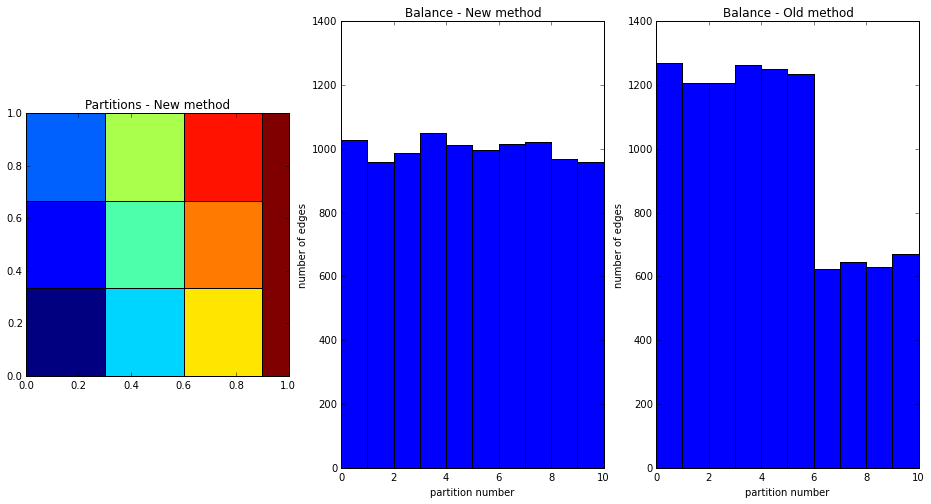

<function __main__.visualize>

In [7]:
interact(visualize, numParts=IntSlider(min=1, max=50, value=10))